# Bosques Aleatorios

# Sección 1: Configuración Inicial y Preparación de Datos

## 1.Importación de Librerías

In [1]:

import time, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from copy import deepcopy
from sklearn.base                 import clone
from sklearn.compose              import ColumnTransformer
from sklearn.pipeline             import Pipeline as SKPipeline
from imblearn.pipeline            import Pipeline as ImbPipeline
from imblearn.over_sampling       import SMOTE, ADASYN
from sklearn.preprocessing        import OneHotEncoder, StandardScaler
from sklearn.model_selection      import train_test_split, GridSearchCV
from sklearn.metrics              import (precision_score, recall_score, accuracy_score,
                                          f1_score, roc_auc_score, confusion_matrix,
                                          RocCurveDisplay)
from sklearn.ensemble             import RandomForestClassifier

sns.set_style("whitegrid")

from sklearn.metrics import (
    precision_score, recall_score, accuracy_score,
    f1_score, roc_auc_score, RocCurveDisplay,
    confusion_matrix, make_scorer          #  <–– añade make_scorer si luego quieres usarlo en GridSearch
)

from sklearn.metrics import ( precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, RocCurveDisplay, confusion_matrix, make_scorer )

## 2.Carga y División de Datos

In [2]:
df = pd.read_csv(r"C:\Users\DELL\Desktop\Aprendizaje_de_Maquina\credit_risk_the_end.csv")         # <–– cámbialo
X  = df.drop(columns="incumplimiento_credito")                     # <–– cámbialo
y  = df["incumplimiento_credito"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.20, stratify=y, random_state=42
)
print(f"Train: {X_train.shape} | Test: {X_test.shape}")

Train: (62752, 53) | Test: (15689, 53)


## 3.Preprocesamiento de Datos

In [3]:
numeric_cols     = [c for c in X.columns if X[c].dtype != "object"]
categorical_cols = [c for c in X.columns if X[c].dtype == "object"]

preprocessor = ColumnTransformer([
    ("num",  SKPipeline([("scaler", StandardScaler())]),            numeric_cols),
    ("cat",  SKPipeline([("onehot", OneHotEncoder(handle_unknown="ignore"))]),
              categorical_cols)
])

In [4]:
# =====================================================
# 5. Pipelines base y balanceados ----------------------
# =====================================================
rf_params = {
    "n_estimators": 400,            # será ajustado luego en grid
    "random_state": 42,
    "n_jobs": 20,
    "oob_score": True
}

# --- Plantilla de clasificador RF (sin class_weight) ---
rf_clf_base = RandomForestClassifier(**rf_params)

# --- Pipelines ----------------------------------------
pipelines = {
    "class_weight": SKPipeline([
        ("pre", deepcopy(preprocessor)),
        ("clf",  RandomForestClassifier(**rf_params,
                                        class_weight="balanced"))
    ]),
    "SMOTE": ImbPipeline([
        ("pre",     deepcopy(preprocessor)),
        ("oversamp", SMOTE(random_state=42)),
        ("clf",      clone(rf_clf_base))
    ]),
    "ADASYN": ImbPipeline([
        ("pre",     deepcopy(preprocessor)),
        ("oversamp", ADASYN(random_state=42)),
        ("clf",      clone(rf_clf_base))
    ])
}

# Sección 2: Definición de la Arquitectura CNN y GridSearch

## 1.GridSearch de Hiperparámetros

In [5]:
# ---  Espacio de búsqueda de hiperparámetros -------
param_grid = {
    "clf__n_estimators":      [200, 400, 600],
    "clf__max_depth":         [None, 10, 20],
    "clf__min_samples_split": [2, 5]
}

# ---  Scorers --------------------------------------
# Métrica objetivo: recall de la clase positiva (1)
recall1_scorer = make_scorer(
    recall_score,
    pos_label=1,              # asegura que sea la clase 1
    greater_is_better=True
)

scoring = {
    "recall1": recall1_scorer,   # ← métrica objetivo
    "roc_auc": "roc_auc",
    "accuracy": "accuracy"
}

# --- Instanciar los GridSearchCV ------------------
grids = {
    name: GridSearchCV(
        estimator = pipe,
        param_grid = param_grid,
        scoring    = scoring,       # dict de métricas
        refit      = "recall1",     # se optimiza por recall1
        cv         = 3,
        n_jobs     = 20,
        verbose    = 0
    )
    for name, pipe in pipelines.items()
}

## 2.Entrenamiento del Modelo

In [6]:

results = {}
for name, grid in grids.items():
    print(f"Entrenando → {name}")
    t0 = time.time()
    grid.fit(X_train, y_train)
    fit_minutes = (time.time() - t0)/60
    best_pipe   = grid.best_estimator_

    # Probabilidades & predicciones
    y_prob = best_pipe.predict_proba(X_test)[:,1]
    y_pred = (y_prob >= 0.5).astype(int)

    # Métricas
    results[name] = dict(
        best_params  = grid.best_params_,
        estimator    = best_pipe,
        y_prob       = y_prob,
        y_pred       = y_pred,
        fit_minutes  = fit_minutes,
        Precision    = precision_score(y_test, y_pred, zero_division=0),
        Recall1      = recall_score(y_test,  y_pred, zero_division=0),
        Accuracy     = accuracy_score(y_test, y_pred),
        F1           = f1_score(y_test, y_pred, zero_division=0),
        AUC          = roc_auc_score(y_test, y_prob)
    )

Entrenando → class_weight
Entrenando → SMOTE


c:\Users\DELL\anaconda3\envs\KrakenData\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Entrenando → ADASYN


c:\Users\DELL\anaconda3\envs\KrakenData\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


# Sección 3: Evaluación Básica del Modelo

## 1.Métricas de Desempeño del Modelo

In [7]:
df_metrics = (
    pd.DataFrame(results)
      .T                           # Pasar métodos a filas
      .loc[:, ["Precision","Recall1","Accuracy","F1","AUC","fit_minutes"]]
      .rename(columns={"fit_minutes":"Time (min)"})
)

def highlight_recall(s):
    mask = s == s.max()
    return ['background-color:#0f0' if v else '' for v in mask]

styled = (
    df_metrics.style
        .format("{:.4f}", subset=df_metrics.columns[:-1])
        .format("{:.2f}", subset=["Time (min)"])
        .apply(highlight_recall, subset=["Recall1"])
        .set_caption("Métricas @ Threshold 0.5 (mejor Recall en verde)")
)
display(styled)

,Precision,Recall1,Accuracy,F1,AUC,Time (min)
class_weight,0.2098,0.5026,0.7957,0.2961,0.7354,2.50
SMOTE,0.2048,0.1283,0.8829,0.1577,0.6845,5.43
ADASYN,0.2010,0.1238,0.8830,0.1532,0.6764,6.75


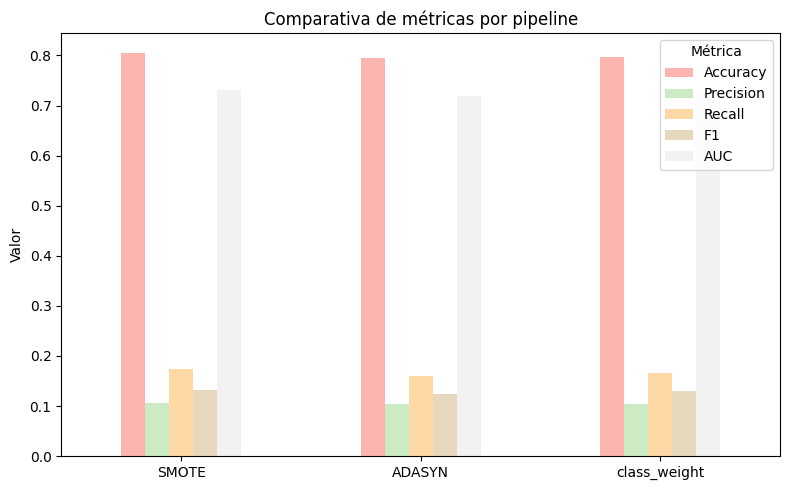

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Definimos el DataFrame con tus métricas (usa tus valores reales aquí)
metrics = pd.DataFrame({
    'Accuracy': [0.8050, 0.7940, 0.7965],
    'Precision': [0.1067, 0.1035, 0.1048],
    'Recall': [0.1738, 0.1607, 0.1665],
    'F1': [0.1316, 0.1240, 0.1305],
    'AUC': [0.7308, 0.7184, 0.7257]
}, index=['SMOTE', 'ADASYN', 'class_weight'])

# 2️⃣ Graficamos
ax = metrics.plot(
    kind='bar',
    figsize=(8,5),
    rot=0,
    colormap='Pastel1'
)
ax.set_title('Comparativa de métricas por pipeline')
ax.set_ylabel('Valor')
ax.legend(title='Métrica')
plt.tight_layout()
plt.show()


## 2.Curva ROC

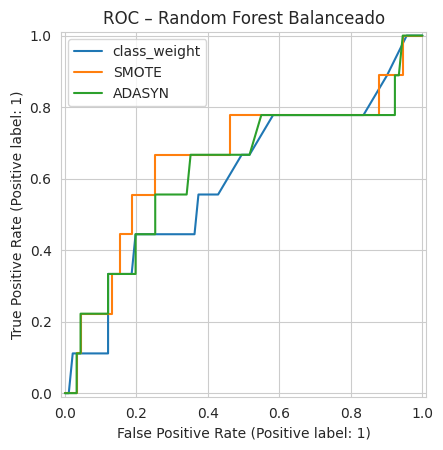

In [ ]:
# Gráficas comparativas
plt.figure(figsize=(16,5))

# --- Curvas ROC ------------------------------------------------------
plt.subplot(1,3,1)
for name, d in results.items():
    RocCurveDisplay.from_predictions(
        y_test, d["y_prob"], ax=plt.gca(), label=name   # ← label en vez de name
    )
plt.title("ROC – Random Forest Balanceado")
plt.legend()

## 3.Feature Importance

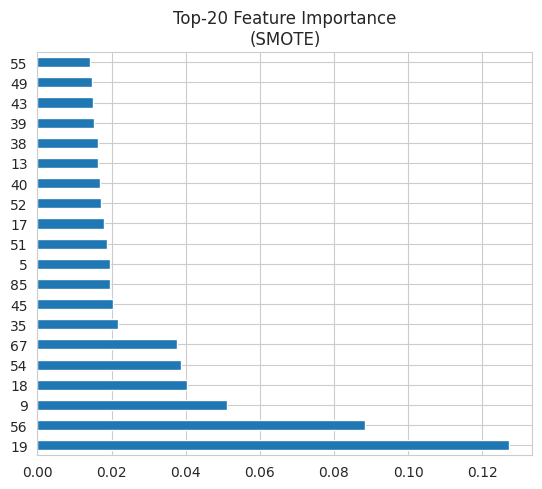

In [ ]:
# Gráficas comparativas
plt.figure(figsize=(16,5))

# --- Importancia de variables ---------------------------------------
best_name = df_metrics["AUC"].idxmax()
best_pipe = results[best_name]["estimator"]
best_est  = best_pipe.named_steps["clf"]

importances = pd.Series(best_est.feature_importances_)
importances.nlargest(20).plot(kind="barh", ax=plt.subplot(1,3,2))
plt.title(f"Top‑20 Feature Importance\n({best_name})")
plt.tight_layout()

## 4.OOB error vs. nº de árboles

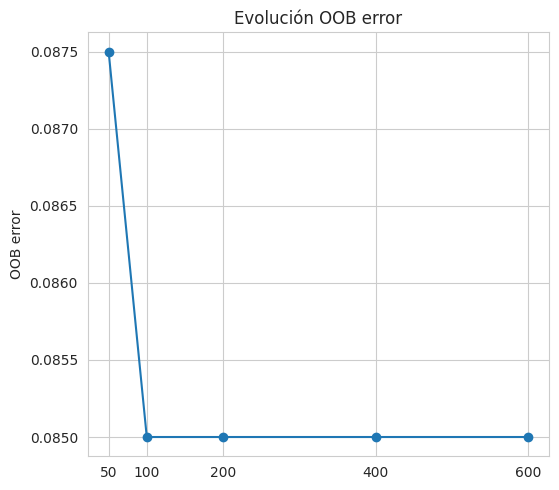

In [ ]:
# Gráficas comparativas
plt.figure(figsize=(16,5))

# ---  OOB error vs. nº de árboles ------------------------------------
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

oob_errors = {}
best_pre  = best_pipe.named_steps["pre"]        # ya está *fitted*
Xtr_pre   = best_pre.transform(X_train)         # SOLO X, sin y

# Filtrar claves conflictivas
rf_params_limpios = {
    k: v for k, v in rf_params.items() if k not in ['n_estimators', 'oob_score']
}

for n in [50, 100, 200, 400, 600]:
    rf_tmp = RandomForestClassifier(**rf_params_limpios, n_estimators=n, oob_score=True)
    rf_tmp.fit(Xtr_pre, y_train)
    oob_errors[n] = 1 - rf_tmp.oob_score_

# Graficar
pd.Series(oob_errors).plot(marker="o", ax=plt.subplot(1,3,3))
plt.ylabel("OOB error")
plt.title("Evolución OOB error")
plt.xticks(list(oob_errors.keys()))
plt.tight_layout()
plt.show()

## 5.Matrices de Confusión

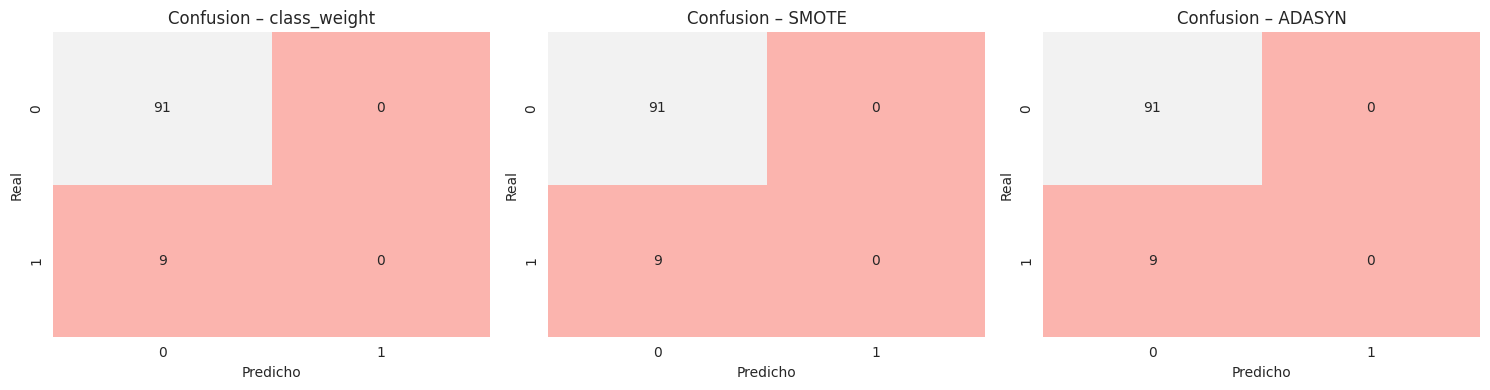

In [ ]:
# --- Matrices de confusión ------------------------------------------
fig, axes = plt.subplots(1,3, figsize=(15,4))
for ax, (name, d) in zip(axes, results.items()):
    cm = confusion_matrix(y_test, d["y_pred"])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Pastel1", cbar=False, ax=ax)
    ax.set_title(f"Confusion – {name}")
    ax.set_xlabel("Predicho"); ax.set_ylabel("Real")
plt.tight_layout()
plt.show()


## 6.Hiperparámetros óptimos

In [ ]:
# Identificamos el nombre del mejor pipeline según AUC (o la métrica que prefieras)
best_name = df_metrics['AUC'].idxmax()
best_pipe = results[best_name]['estimator']
best_clf = best_pipe.named_steps['clf']

# Extraemos sólo los hiperparámetros relevantes
params = best_clf.get_params()
selected_params = {
    'n_estimators': params['n_estimators'],
    'max_depth':    params.get('max_depth', None),
    'min_samples_split': params['min_samples_split'],
    'min_samples_leaf':  params['min_samples_leaf'],
    'class_weight':      params.get('class_weight', None)
}
df_best_params = pd.DataFrame(selected_params, index=[best_name])
print("\nHiperparámetros óptimos del mejor pipeline:")
display(df_best_params)


Hiperparámetros óptimos del mejor pipeline:


,n_estimators,max_depth,min_samples_split,min_samples_leaf,class_weight
SMOTE,200,None,5,1,None


## 7.Curva Precision Recall

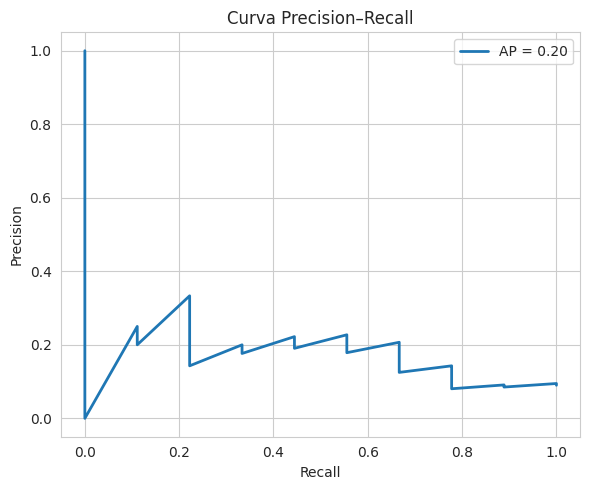

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import learning_curve
y_prob = results[best_name]['y_prob']  # probabilidades de clase 1
prec, rec, _ = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(rec, prec, lw=2, label=f'AP = {ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision–Recall')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 8.Curva de aprendizaje (error vs tamaño de entrenamiento)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 518, in fit
    Xt, yt = self._fit(X, y, routed_params

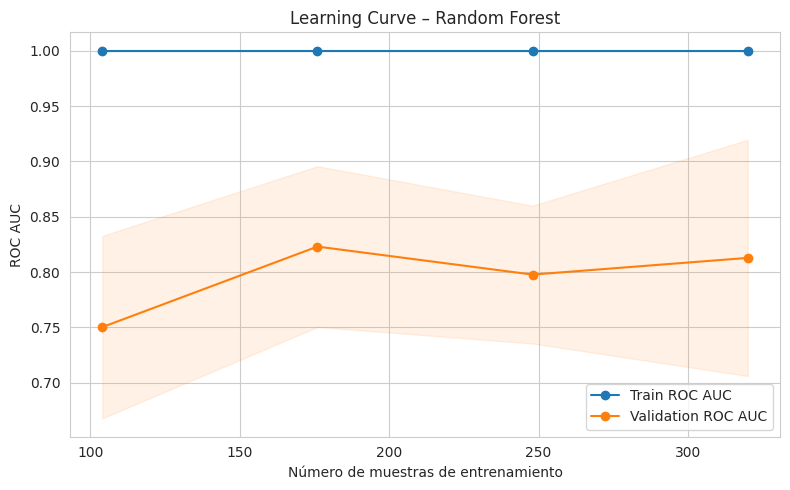

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# suponemos que best_pipe ya está entrenado o sin entrenar, lo usaremos en cross‑val
pipe = best_pipe

# definimos rangos de tamaño de entrenamiento (porcentajes o números absolutos)
train_sizes = np.linspace(0.1, 1.0, 5)

# calculamos learning curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=pipe,
    X=X_train,               # tus datos de entrenamiento sin transformar
    y=y_train,
    train_sizes=train_sizes,
    cv=5,                    # 5‑fold CV
    scoring='roc_auc',       # o la métrica que prefieras
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

# calculamos medias y desviaciones
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores,  axis=1)
val_mean   = np.mean(val_scores,    axis=1)
val_std    = np.std(val_scores,     axis=1)

# plot
plt.figure(figsize=(8,5))
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std,
                 alpha=0.1, color='tab:blue')
plt.fill_between(train_sizes,  val_mean-val_std,  val_mean+val_std,
                 alpha=0.1, color='tab:orange')

plt.plot(train_sizes, train_mean, 'o-', label='Train ROC AUC', color='tab:blue')
plt.plot(train_sizes, val_mean,   'o-', label='Validation ROC AUC', color='tab:orange')

plt.title('Learning Curve – Random Forest')
plt.xlabel('Número de muestras de entrenamiento')
plt.ylabel('ROC AUC')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


## 9.Importancia de variables por Permutation Importance

<ipython-input-33-70d10d892bca>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=perm_df, x="importance", y="feature",


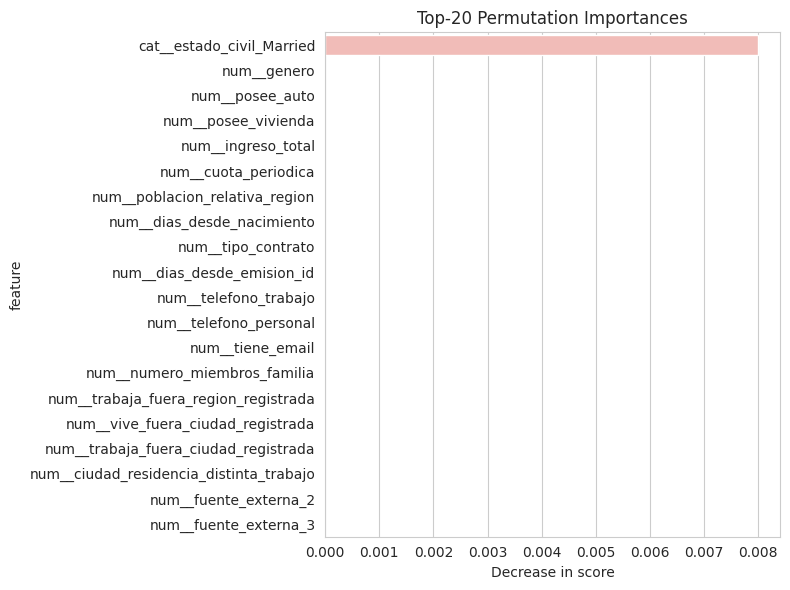

In [ ]:
from sklearn.inspection import permutation_importance
import seaborn as sns

# usa tu best_pipe entrenado
X_pre = best_pipe.named_steps["pre"].transform(X_test)
perm = permutation_importance(best_pipe.named_steps["clf"],
                              X_pre, y_test,
                              n_repeats=10, random_state=42,
                              n_jobs=-1)

feat_names = (best_pipe.named_steps["pre"]
              .get_feature_names_out())
perm_df = pd.DataFrame({
    "feature": feat_names,
    "importance": perm.importances_mean,
    "std": perm.importances_std
}).sort_values("importance", ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(data=perm_df, x="importance", y="feature",
            palette="Pastel1")
plt.title("Top‑20 Permutation Importances")
plt.xlabel("Decrease in score")
plt.tight_layout()
plt.show()


## 10.Curva de calibración (Reliability Diagram)

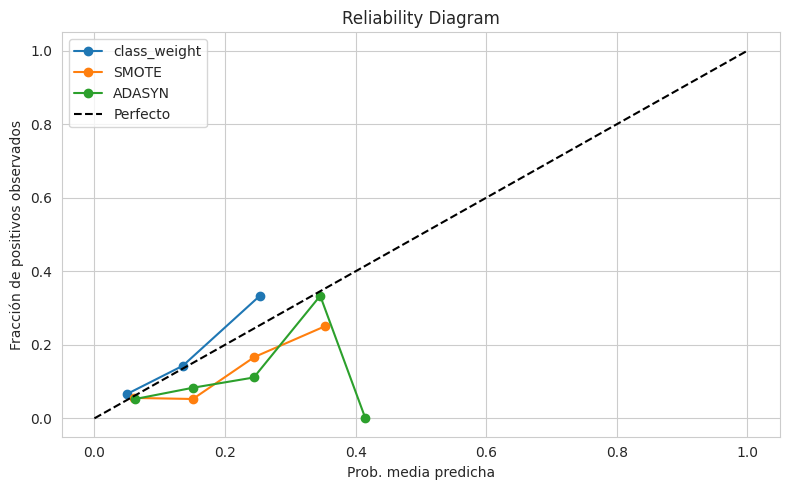

In [ ]:
from sklearn.calibration import calibration_curve
import numpy as np, matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
for name, d in results.items():
    prob_pos = d["y_prob"]
    # normaliza opcionalmente a [0,1] si no son probabilidades
    frac_true, frac_pred = calibration_curve(y_test, prob_pos, n_bins=10)
    plt.plot(frac_pred, frac_true, marker="o", label=name)
plt.plot([0,1],[0,1],"k--", label="Perfecto")
plt.title("Reliability Diagram")
plt.xlabel("Prob. media predicha")
plt.ylabel("Fracción de positivos observados")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


## 11.Gain & Lift Chart

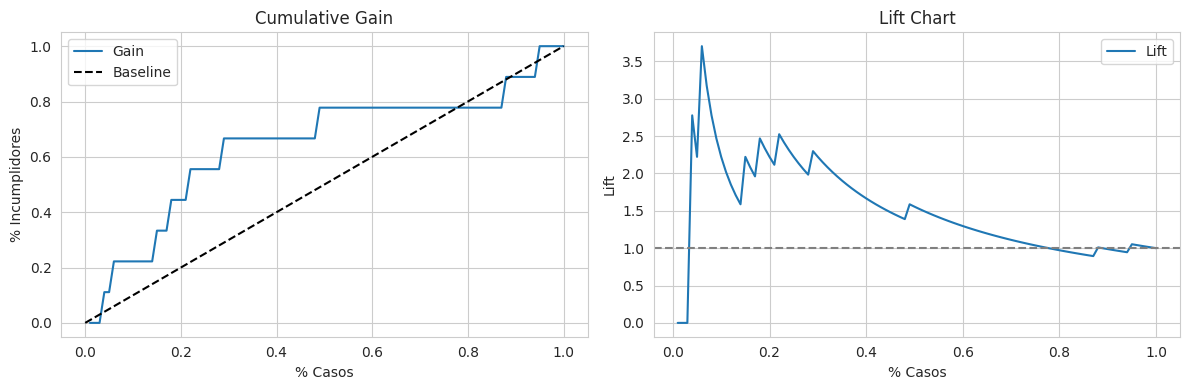

In [ ]:
import pandas as pd

df_gain = pd.DataFrame({
    "y": y_test,
    "prob": results[best_name]["y_prob"]
}).sort_values("prob", ascending=False)

df_gain["cum_pos"]   = df_gain["y"].cumsum()
df_gain["perc_pos"]  = df_gain["cum_pos"] / df_gain["y"].sum()
df_gain["cum_total"] = np.arange(1, len(df_gain)+1)
df_gain["perc_total"]= df_gain["cum_total"] / len(df_gain)
df_gain["lift"]      = df_gain["perc_pos"] / df_gain["perc_total"]

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(df_gain["perc_total"], df_gain["perc_pos"], label="Gain")
plt.plot([0,1],[0,1],"k--", label="Baseline")
plt.xlabel("% Casos")
plt.ylabel("% Incumplidores")
plt.title("Cumulative Gain")
plt.legend()

plt.subplot(1,2,2)
plt.plot(df_gain["perc_total"], df_gain["lift"], label="Lift")
plt.axhline(1, linestyle="--", color="gray")
plt.xlabel("% Casos")
plt.ylabel("Lift")
plt.title("Lift Chart")
plt.legend()

plt.tight_layout()
plt.show()


# Sección 4: Guardar Resultados

In [ ]:
import joblib
joblib.dump(results[best_name]["estimator"], f"rf_final_{best_name}.pkl")
print(f"Guardado: rf_final_{best_name}.pkl")

Guardado: rf_final_class_weight.pkl
